# Safety-Aware Implementation of Control Tasks via Scheduling with Period Boosting and Compressing

In [3]:
using Plots
using LaTeXStrings
using ControlSystemsBase
using DelimitedFiles

using ControlSafetyBench
using ControlTimingSafety

push!(LOAD_PATH, "../lib")
using Experiments

[ Info: Precompiling Experiments [top-level]


## Explore Systems and Set up Parameters

In [2]:
sysc = benchmarks[:F1]

StateSpace{Continuous, Float64}
A = 
 0.0  6.5
 0.0  0.0
B = 
  0.0
 19.68503937007874
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [7]:
H = 100
d_max = 1000
maxwindow = 6
params = (
    RC = (p = 23, d = 5.8,  x0 = 100, n = 10),
    F1 = (p = 20, d = 0.37, x0 = 1,   n = 15),
    DC = (p = 23, d = 0.18, x0 = 100, n = 10),
    CS = (p = 27, d = 2.1,  x0 = 100, n = 15),
    CC = (p = 28, d = 0.48, x0 = 1,   n = 15))
K(s::Symbol, p::Integer) = delay_lqr(benchmarks[s], 0.001*p)
K(s::Symbol) = K(s, params[s][:p])
K(:RC)

1×3 Matrix{Float64}:
 0.160079  0.214257  0.0221421

Comparing the two nominal trajectories:
- `nominal1`: the original trajectory with $p$ ms period
- `nominal2`: a trajectory with $1$ ms period that simulates the original nominal behavior with a much finer interval.

The `nominal2` trajectory is simulated with every $p$-th deadline being a hit, and all other deadlines being misses. To simulate the logical execution time (LET) paradigm, where the sampling of system state and application of control input is $p$ ms apartm the `Hold&SkipNext` policy is used to ensure the $p$ ms delay in control input calculation.

In [13]:
let
    nominal1 = trajectory_coarse(benchmarks[:F1], K(:F1), params[:F1][:x0], params[:F1][:p], H)
    nominal2 = nominal_trajectory(benchmarks[:F1], K(:F1), params[:F1][:x0], params[:F1][:p], H)
    slice_nominal(nominal2, params[:F1][:p]) ≈ nominal1
end

true

In [37]:
nominal = (
    RC = nominal_trajectory(benchmarks[:RC], K(:RC), params[:RC][:x0], params[:RC][:p], H),
    F1 = nominal_trajectory(benchmarks[:F1], K(:F1), params[:F1][:x0], params[:F1][:p], H),
    DC = nominal_trajectory(benchmarks[:DC], K(:DC), params[:DC][:x0], params[:DC][:p], H),
    CS = nominal_trajectory(benchmarks[:CS], K(:CS), params[:CS][:x0], params[:CS][:p], H),
    CC = nominal_trajectory(benchmarks[:CC], K(:CC), params[:CC][:x0], params[:CC][:p], H))
output(s::Symbol) = benchmarks[s].C * nominal[s]
output(:RC)

2×2301 Matrix{Float64}:
 100.0  99.5015  99.0059  98.5132  …  -0.205483  -0.205453  -0.205435
 100.0  99.95    99.8999  99.8497     15.9149    15.902     15.8891

## Synthesizing Constraints and Compare with Non-Period-Boosted Solution

We first compare the nominal trajectory (no deadline misses) of original and 
changed periods, both with and without recomputing the control gains.

In [27]:
out_f1_15_re = benchmarks[:F1].C * nominal_trajectory(benchmarks[:F1], K(:F1, 15), params[:F1][:x0], 15, H)
out_f1_15 =    benchmarks[:F1].C * nominal_trajectory(benchmarks[:F1], K(:F1, 20), params[:F1][:x0], 15, H)
out_f1_20 =    benchmarks[:F1].C * nominal_trajectory(benchmarks[:F1], K(:F1, 20), params[:F1][:x0], 20, H)

1×2001 Matrix{Float64}:
 1.0  1.0065  1.013  1.0195  1.026  …  8.72126e-7  8.65249e-7  8.5843e-7

In [28]:
maximum(out_f1_15_re - out_f1_20[:,1:1501])

0.0

In [29]:
maximum(out_f1_15 -    out_f1_20[:,1:1501])

0.030099027380028676

In [31]:
slice_nominal(out_f1_15, 15) ≈ benchmarks[:F1].C * trajectory_coarse(benchmarks[:F1], K(:F1, 20), params[:F1][:x0], 15, H)

true

The reference method without any period boosting

In [38]:
ref(s::Symbol) = synthesize_constraints(c2d(benchmarks[s], params[s][:p]*0.001),
    K(s), x_to_z_kill(benchmarks[s], params[s][:x0]), d_max, maxwindow, 
    params[s][:n], H, fullresults=true, nominal=slice_nominal(output(s), params[s][:p]))[2];

In [39]:
ref(:DC)

6×6 Matrix{Float64}:
 1.19209e-7  Inf          Inf          Inf          Inf          Inf
 0.0621409    1.19209e-7  Inf          Inf          Inf          Inf
 0.12127      0.0621409    1.19209e-7  Inf          Inf          Inf
 0.177329     0.12127      0.0621409    1.19209e-7  Inf          Inf
 0.230245     0.177325     0.12127      0.0621409    1.19209e-7  Inf
 0.280584     0.230228     0.177325     0.12127      0.0621409    1.19209e-7

Constraint synthesis with period boosting

In [73]:
pb(s::Symbol, newp::Integer, recompute=false) = period_boosting(
    benchmarks[s], 
    if recompute K(s, newp) else K(s) end, 
    newp, x_to_z_kill(benchmarks[s], params[s][:x0]), 
    d_max, maxwindow, params[s][:n], output(s));

Compare two approaches with original period ($23$ ms). There should not be any differences in this case.

In [41]:
pb(:DC, 23) - ref(:DC)

6×6 Matrix{Float64}:
 0.0  NaN    NaN    NaN    NaN    NaN
 0.0    0.0  NaN    NaN    NaN    NaN
 0.0    0.0    0.0  NaN    NaN    NaN
 0.0    0.0    0.0    0.0  NaN    NaN
 0.0    0.0    0.0    0.0    0.0  NaN
 0.0    0.0    0.0    0.0    0.0    0.0

Compare the original with a new period $p=28$ ms. The values below
are the net changes between the two periods. In this case, all constraints have higher deviations.

In [42]:
pb(:DC, 40) - ref(:DC)

6×6 Matrix{Float64}:
 0.0336125  NaN          NaN          NaN          NaN          NaN
 0.073706     0.0336125  NaN          NaN          NaN          NaN
 0.109843     0.073706     0.0336125  NaN          NaN          NaN
 0.138963     0.109843     0.073706     0.0336125  NaN          NaN
 0.159788     0.138966     0.109843     0.073706     0.0336125  NaN
 0.177201     0.159806     0.138966     0.109843     0.073706     0.0336125

In [43]:
pb(:DC, 40, true) - ref(:DC)

6×6 Matrix{Float64}:
 0.0467786  NaN          NaN          NaN          NaN          NaN
 0.086938     0.0467786  NaN          NaN          NaN          NaN
 0.119422     0.086938     0.0467786  NaN          NaN          NaN
 0.147288     0.119422     0.086938     0.0467786  NaN          NaN
 0.16744      0.147292     0.119422     0.086938     0.0467786  NaN
 0.18085      0.167458     0.147292     0.119422     0.086938     0.0467786

## Experiments

In [86]:
res = Dict()

for sys in [:RC, :F1, :DC, :CS, :CC], newp in [15, 28, 40]
    res[(sys, newp)] = pb(sys, newp)
    @info sys newp res[(sys, newp)]
    writedlm("../data/$sys-$newp.tsv", round.(res[(sys, newp)], sigdigits=5), '\t')
end

┌ Info: CC
│   newp = 15
│   res[(sys, newp)] =
│    6×6 Matrix{Float64}:
│     0.0214848  Inf         Inf         Inf         Inf         Inf
│     0.204227    0.0214848  Inf         Inf         Inf         Inf
│     0.439042    0.170434    0.0214848  Inf         Inf         Inf
│     0.73007     0.383821    0.151545    0.0214848  Inf         Inf
│     1.10916     0.668262    0.344042    0.140183    0.0214848  Inf
└     1.56022     1.01687     0.597671    0.318105    0.133024    0.0214848
┌ Info: CC
│   newp = 28
│   res[(sys, newp)] =
│    6×6 Matrix{Float64}:
│     2.10734e-8  Inf          Inf          …  Inf          Inf
│     0.137146     2.10734e-8  Inf             Inf          Inf
│     0.297359     0.106627     2.10734e-8     Inf          Inf
│     0.48143      0.244919     0.0913221      Inf          Inf
│     0.693404     0.411671     0.214667        2.10734e-8  Inf
└     0.925013     0.605132     0.367913    …   0.0771067    2.10734e-8
┌ Info: CC
│   newp = 40
│   res[(sys, 

In [85]:
res_re = Dict()

for sys in [:RC, :F1, :DC, :CS, :CC], newp in [15, 28, 40]
    res_re[(sys, newp)] = pb(sys, newp, true)
    @info sys newp res_re[(sys, newp)]
    writedlm("../data/$sys-$newp-RE.tsv", round.(res_re[(sys, newp)], sigdigits=5), '\t')
end

┌ Info: RC
│   newp = 15
│   res_re[(sys, newp)] =
│    6×6 Matrix{Float64}:
│     1.50654  Inf       Inf       Inf       Inf       Inf
│     1.50654   1.50654  Inf       Inf       Inf       Inf
│     3.88435   1.50654   1.50654  Inf       Inf       Inf
│     6.07337   3.88435   1.50654   1.50654  Inf       Inf
│     7.99598   6.07337   3.88435   1.50654   1.50654  Inf
└     9.65662   7.99598   6.07337   3.88435   1.50654   1.50654
┌ Info: RC
│   newp = 28
│   res_re[(sys, newp)] =
│    6×6 Matrix{Float64}:
│      0.926941  Inf        Inf        Inf        Inf        Inf
│      5.51169    0.926941  Inf        Inf        Inf        Inf
│      9.00937    5.51169    0.926941  Inf        Inf        Inf
│     11.6484     9.00937    5.51169    0.926941  Inf        Inf
│     13.5953    11.6484     9.00937    5.51169    0.926941  Inf
└     14.9956    13.5953    11.6484     9.00937    5.51169    0.926941
┌ Info: RC
│   newp = 40
│   res_re[(sys, newp)] =
│    6×6 Matrix{Float64}:
│      3.04462

## Plotting

In [88]:
quicktraj(s::Symbol, newp::Integer, sch::Vector{Int64}; t::Integer=size(nominal[s], 2)-1, recompute=false) = trajectory(
    benchmarks[s], 
    if recompute K(s, newp) else K(s) end,
    params[s][:x0],
    newp,
    t,
    σ=schedule_to_sequence(sch, t÷newp));

In [89]:
quicktraj(:F1, 40, [0, 1], recompute=true)

2×2001 Matrix{Float64}:
 1.0  1.0065  1.013  1.0195  1.026  …  -0.0198376  -0.0214114  -0.0229895
 1.0  1.0     1.0    1.0     1.0       -0.241785   -0.242456   -0.243127

In [81]:
nominal[:F1]

2×2001 Matrix{Float64}:
 1.0  1.0065  1.013  1.0195  1.026  1.0325  …   8.65249e-7   8.5843e-7
 1.0  1.0     1.0    1.0     1.0    1.0        -1.05356e-6  -1.04459e-6

In [251]:
profiles = (
    F128RE = (label = "28 ms w/ redesign",  γ = quicktraj(:F1, 28, [1], recompute=true)),
    F128   = (label = "28 ms w/o redesign", γ = quicktraj(:F1, 28, [1], recompute=false)),
    F140RE = (label = "40 ms w/ redesign",  γ = quicktraj(:F1, 40, [1], recompute=true)),
    F140   = (label = "40 ms w/o redesign", γ = quicktraj(:F1, 40, [1, 0], t=1000, recompute=false)),
    CC28RE = (label = "28 ms w/ redesign",  γ = quicktraj(:CC, 28, [0, 1, 0], recompute=true)),
    CC28   = (label = "28 ms w/o redesign", γ = quicktraj(:CC, 28, [0, 1, 0], recompute=false)),
    CC40RE = (label = "40 ms w/ redesign",  γ = quicktraj(:CC, 40, [1, 0, 0, 0], recompute=true)),
    CC40   = (label = "40 ms w/o redesign", γ = quicktraj(:CC, 40, [1, 0, 0, 0], recompute=false)))
profiles[:F140][:γ]
profiles[:CC28][:γ]

3×2801 Matrix{Float64}:
 1.0  1.001     1.002     1.003     …   0.106102    0.106083    0.106063
 1.0  1.00099   1.00198   1.00295      -0.0194144  -0.0195448  -0.0196754
 1.0  0.988425  0.976841  0.965248     -0.130217   -0.130476   -0.130735

In [268]:
pd(s::Symbol, pfs::Vector{Symbol}; az::Real=50, el::Real=35, ar::Real=1, legend::Symbol=:outertopright, title::String="") = plotdev(
    nominal[s],
    params[s][:p],
    params[s][:x0],
    params[s][:d],
    [profiles[pf][:label] => profiles[pf][:γ] for pf in pfs],
    az,
    el,
    ar,
    legend,
    title);

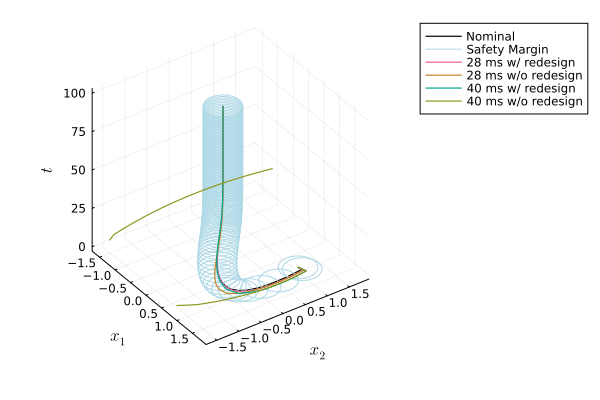

In [289]:
fig_f1 = pd(:F1, [:F128RE, :F128, :F140RE, :F140], az=55)

[ Info: Saved animation to /home/jerry/Projects/date23/fig/CC.gif


Plots.AnimatedGif("/home/jerry/Projects/date23/fig/CC.gif")
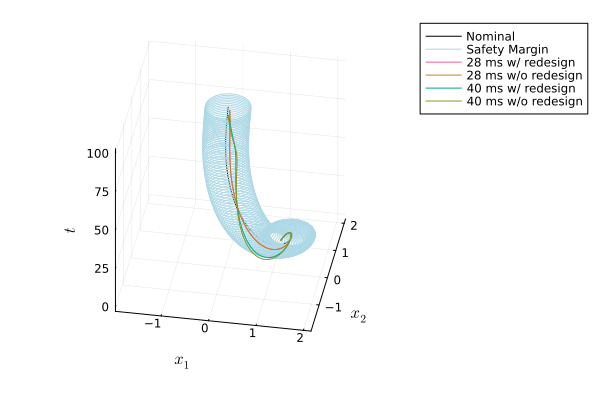

In [281]:
anim = @animate for i ∈ 10:80
    pd(:CC, [:CC28RE, :CC28, :CC40RE, :CC40], az=i)
end
gif(anim, "../fig/CC.gif", fps = 5)

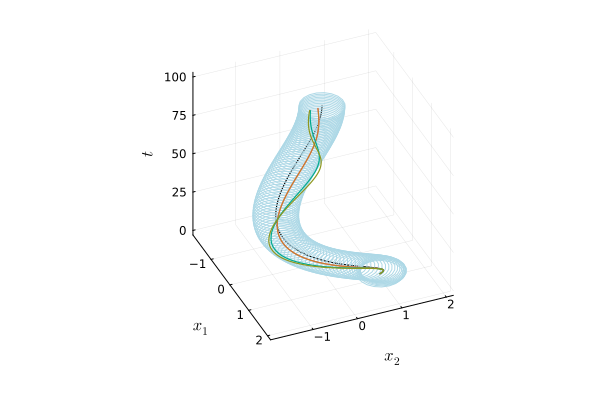

In [288]:
fig_cc = pd(:CC, [:CC28RE, :CC28, :CC40RE, :CC40], az=67, legend=:none)

In [261]:
size(fig_f1)

(1, 1)

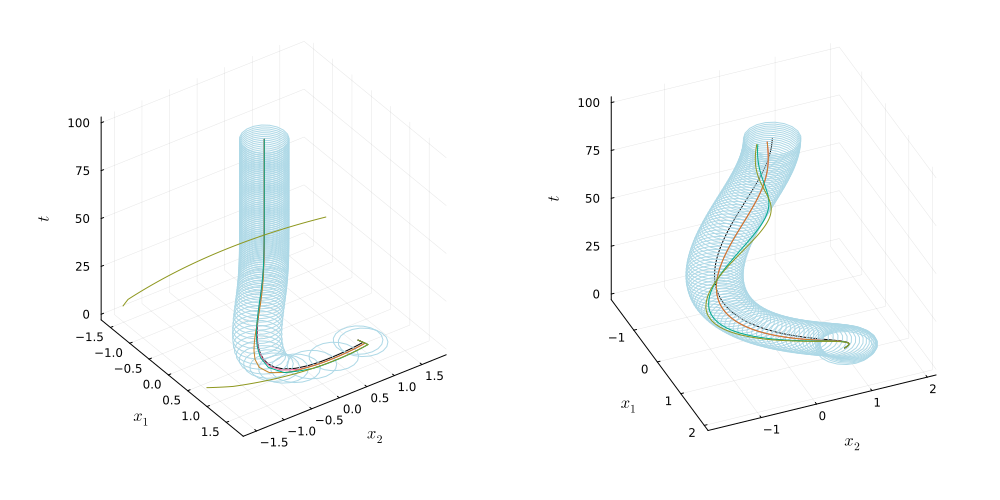

In [275]:
fig = plot(fig_f1, fig_cc, layout=(1, 2), legend=false, size=(1000, 500))

In [276]:
savefig(fig_f1, "../fig/F1.svg")
savefig(fig_cc, "../fig/CC.svg")
savefig(fig, "../fig/fig.svg")

"/home/jerry/Projects/date23/fig/fig.svg"